## Week3 Lab section
- In this tutorial, we will import pretrained Generative model, and explore two important evaluation metrics for assessing the quality of generated images: the Inception Score (IS) and the Fréchet Inception Distance (FID). We will follow a step-by-step approach to achieve the following objectives:

1. Import Pretrained PGAN Model:
```python
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
```

2. Generate New image
```python
generated_images = model.test(noise)
```


3. Import Inception model (imageNet-1000)
```python
# Preprocessing steps
preprocess = Compose([
    Resize((299, 299)),  # Resize to 299x299
    ToTensor(),          # Convert to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
```
```python
inception_model = inception_v3(pretrained=True, transform_input=False)
```
4. Calculate Inception Score (IS):
- Real vs. Fake
- Real vs. Real

5. Calculate Fréchet Inception Distance (FID):
- Real vs. Fake
- Real vs. Real

# Progressive Growing of GANs (PGAN)

*Author: FAIR HDGAN*

**High-quality image generation of fashion, celebrity faces**

_ | _
- | -
![alt](https://pytorch.org/assets/images/pgan_mix.jpg) | ![alt](https://pytorch.org/assets/images/pgan_celebaHQ.jpg)

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
import os
import random
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
from torchvision.transforms import ToPILImage
from scipy.linalg import sqrtm
import torch.nn.functional as F
from scipy.stats import entropy
import torch.nn as nn
import numpy as np
import random

use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


The input to the model is a noise vector of shape `(N, 512)` where `N` is the number of images to be generated.
It can be constructed using the function `.buildNoiseData`.
The model has a `.test` function that takes in the noise vector and generates images.

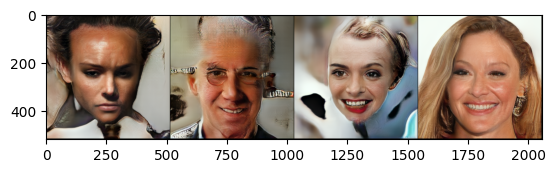

In [ ]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# plt.show()

In [ ]:
# Generate images
num_images = 32
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)  # Assuming this returns a batch of tensors


### 1. Output of the Inception v3 model is typically used in IS, FID.
### 2. By default, it does not include the final softmax layer.
### 3. Therefore we manually add softmax layer to acquire probability outputs.

```pyton
probs = [F.softmax(pred, dim=0) for pred in preds]
```

![inceptionV2.png](attachment:inceptionV2.png)

In [ ]:
for name, layer in inception_model.named_children():
    print(f"Layer Name: {name}")
    print(layer)
    print("\n")

![Picture1.png](attachment:Picture1.png)

In [ ]:
# Preprocessing steps
preprocess = Compose([
    Resize((299, 299)),  # Resize to 299x299
    ToTensor(),          # Convert to tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

def calculate_inception_score(images, model):
    model.eval()

    preds = model(images)
    probs = F.softmax(preds, dim=1)  # Apply softmax across the classes dimension

    # Calculate the marginal distribution
    py = probs.mean(dim=0)  # Take the mean across the batch dimension

    # Compute the KL divergence and Inception Score
    scores = [entropy(prob.detach().numpy(), py.detach().numpy()) for prob in probs]

    # Calculate the Inception Score
    IS_mean = np.exp(np.mean(scores))

    return IS_mean


features = None
def calculate_fid(real_images, fake_images, model):
    model.eval()  # Set the model to evaluation mode
    # Function to hook the penultimate layer
    def get_penultimate_features(module, input, output):
        global features
        features = output.detach()

    # Register hook
    layer = model._modules.get('avgpool')
    hook = layer.register_forward_hook(get_penultimate_features)

    # Forward pass for fake images
    model(fake_images)
    feature_fake = features


    # Forward pass for real images
    model(real_images)
    feature_real = features

    # Remove the hook
    hook.remove()

    # Process features to get mean and covariance
    feature_fake = feature_fake.squeeze()
    feature_real = feature_real.squeeze()
    mu1, sigma1 = feature_fake.mean(axis=0), np.cov(feature_fake, rowvar=False)
    mu2, sigma2 = feature_real.mean(axis=0), np.cov(feature_real, rowvar=False)

    # Calculate FID
    ssdiff = torch.sum((mu1 - mu2)**2.0)
    covmean = sqrtm((sigma1 + 1e-6 * np.eye(sigma1.shape[0])).dot(sigma2 + 1e-6 * np.eye(sigma2.shape[0])))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


## We prepare the images for calculating the Inception Score (IS) and Fréchet Inception Distance (FID) using
- A set of generated images (referred to as "fake images")

- A set of real images from the Celebrity Face dataset, you can follow these steps:

In [ ]:
# Generate images
num_images = 32
noise, _ = model.buildNoiseData(num_images) # model already has Noise generation functoin
print(noise.size())
generated_images = model.test(noise)  # Assuming this returns a batch of tensors

# Initialize an empty list to store processed images
fake_images = []

to_pil = ToPILImage()
# Preprocess each generated image
for img in generated_images:
    img_pil = to_pil(img)  # Convert tensor to PIL Image
    processed_img = preprocess(img_pil)  # Apply the preprocess directly on the tensor
    fake_images.append(processed_img)


torch.Size([32, 512])


## You can manually update this data to the colab: 32 images might be enough


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d farzadnekouei/50k-celebrity-faces-image-dataset
! unzip -q 50k-celebrity-faces-image-dataset.zip -d Kaggle

Saving kaggle.json to kaggle (1).json
50k-celebrity-faces-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Kaggle/Celebrity_Faces_Dataset/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Kaggle/Celebrity_Faces_Dataset/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## I used only 32 images but this number is insufficient to estimate covariance, in real experimental setting they use at least 50 - 1000 images in the single batch.



In [ ]:
import os
import random
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image


# Set the directory where your images are located
image_directory = 'Kaggle/Celebrity_Faces_Dataset'  # Modify as needed

# Get a list of filenames in the directory
all_files = os.listdir(image_directory)

# Filter out non-image files if necessary
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 32 images
selected_images = image_files[:32]

real_images = []
for filename in selected_images:
    img_path = os.path.join(image_directory, filename)
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)
    real_images.append(img)

## Inception score for
- random image
- fake(generated) image
- real image

### Inceptoin score finds the differences between P(y|x), and P(Y), so higher number is better.

In [ ]:
inception_model = inception_v3(pretrained=True, transform_input=False)

random_tensor = torch.randn(32, 3, 299, 299)
print(calculate_inception_score(random_tensor, inception_model))
print(calculate_inception_score(torch.stack(fake_images), inception_model))
print(calculate_inception_score(torch.stack(real_images), inception_model))

1.096405
1.5844784
3.47055


## FID score between real images and fake image
- FID assesses the similarity in feature distributions between real and fake images.
- It leverages a CNN model, typically Inception v3, to extract high-dimensional features from both image sets.
- If the generated (fake) images exhibit feature patterns similar to those in real images, as encoded by the CNN's neurons, it implies a closer alignment in their feature distributions.
- Therefore, a lower FID score signifies greater similarity

In [ ]:
model = inception_v3(pretrained=True)
print(calculate_fid(torch.stack(real_images), torch.stack(fake_images), model))
print(calculate_fid(torch.stack(real_images), torch.stack(real_images), model))

tensor(299.7365)
tensor(-0.0041)


If you want to train your own Progressive GAN and other GANs from scratch, have a look at [PyTorch GAN Zoo](https://github.com/facebookresearch/pytorch_GAN_zoo).

### Model Description

Progressive Growing of GANs is a method developed by Karras et. al. [1] in 2017 allowing generation of high resolution images. To do so, the generative network is trained slice by slice. At first the model is trained to build very low resolution images, once it converges, new layers are added and the output resolution doubles. The process continues until the desired resolution is reached.

### References

[1] Tero Karras et al, "Progressive Growing of GANs for Improved Quality, Stability, and Variation" https://arxiv.org/abs/1710.10196

## Task - Utilize a Pretrained Generative Model to Create Images and Evaluate the images with IS and FID score

- Import any pretrained generative models (including ~one diffusion model) and then generate a set of images (up to 32).
- you can even use your model (or uploaded mode by instructor) from the prevoius homework
- FID Score Calculation: For the Fréchet Inception Distance (FID) evaluation, obtain a sample of real images from the same domain as the one on which your model was trained. If accessing such a dataset is challenging, you may alternatively use a relevant subset from a standard dataset like ImageNet or CelebA (less than 100 images).
- Flexibility in Implementation: If the provided code here does not align well with your chosen model, feel free to adapt or source alternative code as needed to facilitate the calculations.

#### If you couldn't finish the homework due to many reason (limitation of the resource, unresolved error), then just submit your last update, and describe what you have tried, and what was the current issue (problem).

------------

# Setup: Kaggle API & CelebA Dataset Download

First, upload your `kaggle.json` file (from Kaggle Account → API → Create New Token)

In [28]:
!pip install kaggle diffusers accelerate transformers clean-fid pytorch-fid lpips torch-fidelity open_clip_torch
!pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.6 MB/s eta 0:00:00


In [4]:
from google.colab import files
import os

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle credentials
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [5]:
# Download CelebA dataset (aligned & cropped faces)
!kaggle datasets download -d jessicali9530/celeba-dataset

# Unzip the dataset
!unzip -q celeba-dataset.zip -d celeba_data
!rm celeba-dataset.zip

print("CelebA dataset downloaded and extracted!")
print(f"Dataset location: ./celeba_data/")

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.31G/1.33G [00:09<00:00, 254MB/s]
100% 1.33G/1.33G [00:10<00:00, 142MB/s]
CelebA dataset downloaded and extracted!
Dataset location: ./celeba_data/


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.stats import entropy
import os
import random
from tqdm.auto import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed=67):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(67)

Using device: cuda


Loading real images:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 real images, shape: torch.Size([50, 3, 256, 256])


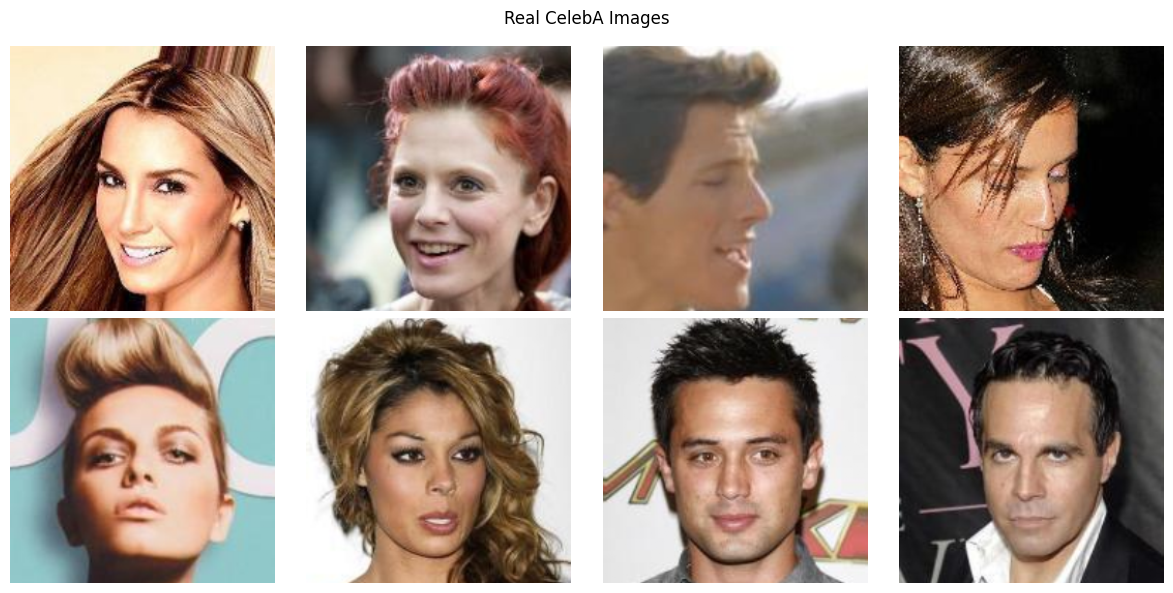

In [7]:
def load_real_images(data_dir, num_images=32, image_size=256):
    """Load real images from CelebA dataset"""
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

    # Find the actual image directory
    img_dir = os.path.join(data_dir, 'img_align_celeba', 'img_align_celeba')
    if not os.path.exists(img_dir):
        img_dir = os.path.join(data_dir, 'img_align_celeba')

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])[:num_images]

    images = []
    for img_file in tqdm(image_files, desc="Loading real images"):
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        images.append(img_tensor)

    return torch.stack(images)

# Load 50 real images for evaluation
real_images = load_real_images('celeba_data', num_images=50, image_size=256)
print(f"Loaded {len(real_images)} real images, shape: {real_images.shape}")

# Visualize some real images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = (real_images[i].permute(1, 2, 0).numpy() + 1) / 2  # Denormalize
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Real CelebA Images')
plt.tight_layout()
plt.show()

---
# Model 1: DCGAN (Basic GAN)
A simple Deep Convolutional GAN - the baseline model for comparison.

In [11]:
from huggingface_hub import hf_hub_download
import json

# DCGAN trained on CelebA from HuggingFace Hub
# Using a community model trained on CelebA 64x64
class DCGANGenerator(nn.Module):
    """DCGAN Generator for 64x64 images"""
    def __init__(self, latent_dim=100, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )

    def forward(self, z):
        return self.main(z)

# Load pretrained DCGAN from HuggingFace
model_path = hf_hub_download(repo_id="hussamalafandi/DCGAN_CelebA", filename="generator.pth")

# Instantiate the generator model
dcgan_generator = DCGANGenerator(latent_dim=100, ngf=64).to(device)

# Load the state dictionary into the instantiated model
dcgan_generator.load_state_dict(torch.load(model_path, map_location=device))
print("Loaded DCGAN from HuggingFace Hub")

dcgan_generator.eval()
print(f"DCGAN Generator loaded on {device}")

Loaded DCGAN from HuggingFace Hub
DCGAN Generator loaded on cuda


DCGAN: Generated 50 images in 1.041 seconds
   Image shape: torch.Size([50, 3, 64, 64])


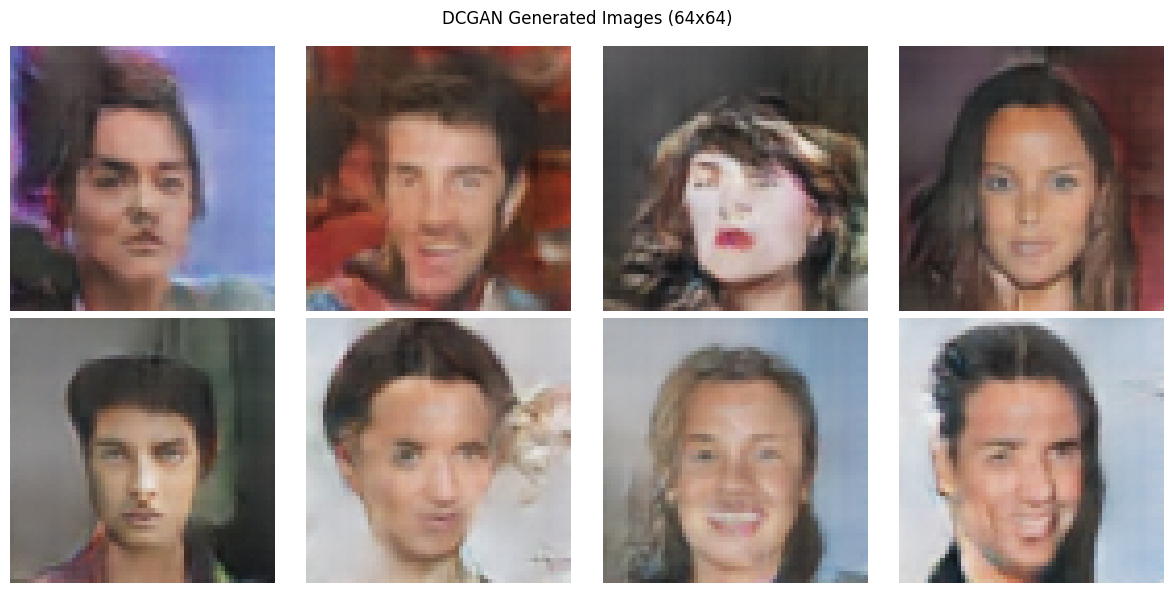

In [12]:
import time

def generate_dcgan_images(generator, num_images=32, latent_dim=100):
    """Generate images using DCGAN"""
    generator.eval()
    with torch.no_grad():
        # Random latent vectors
        z = torch.randn(num_images, latent_dim, 1, 1, device=device)
        start_time = time.time()
        generated = generator(z)
        inference_time = time.time() - start_time
    return generated, inference_time

# Generate 50 images
dcgan_images, dcgan_time = generate_dcgan_images(dcgan_generator, num_images=50)
print(f"DCGAN: Generated {len(dcgan_images)} images in {dcgan_time:.3f} seconds")
print(f"   Image shape: {dcgan_images.shape}")

# Resize to 256x256 for fair comparison with other models
dcgan_images_resized = F.interpolate(dcgan_images, size=(256, 256), mode='bilinear', align_corners=False)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = (dcgan_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
plt.suptitle('DCGAN Generated Images (64x64)')
plt.tight_layout()
plt.show()

---
# Model 2: LDM - Latent Diffusion Model (CompVis)
Latent Diffusion Model trained on CelebA-HQ - generates images in latent space then decodes.

In [13]:
from diffusers import DiffusionPipeline

# Load pretrained LDM on CelebA-HQ 256x256
ldm_pipeline = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipeline = ldm_pipeline.to(device)

print("LDM (Latent Diffusion Model) loaded")
print(f"   Model: CompVis/ldm-celebahq-256")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae.

LDM (Latent Diffusion Model) loaded
   Model: CompVis/ldm-celebahq-256


⏳ Generating LDM images...


Generating LDM images:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

LDM: Generated 50 images in 141.7 seconds


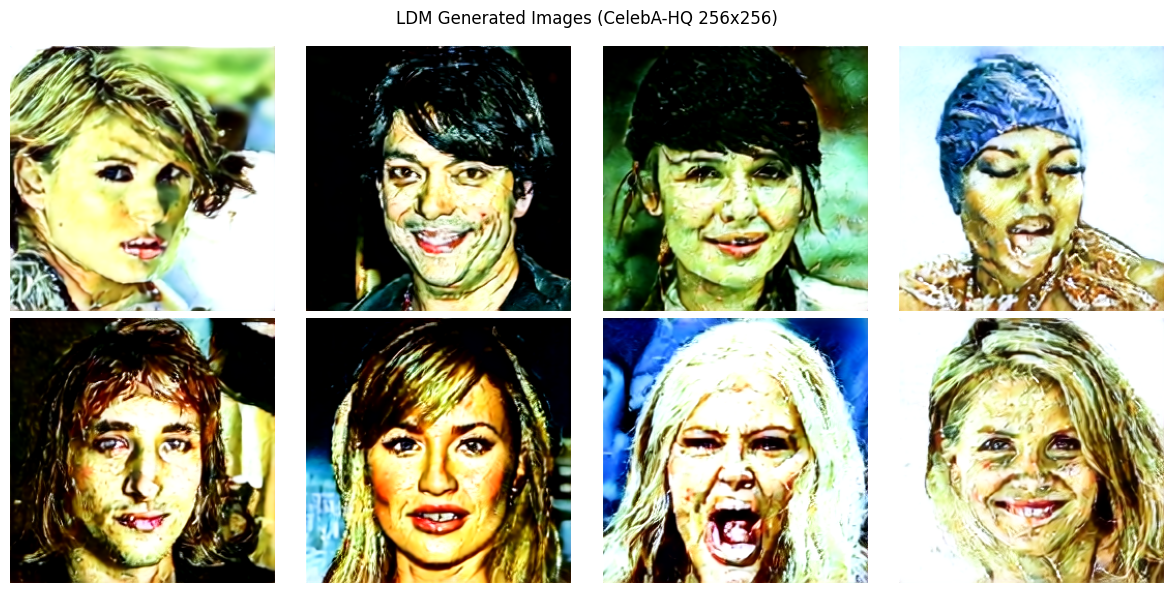

In [15]:
def generate_ldm_images(pipeline, num_images=50, batch_size=10, num_inference_steps=50):
    """Generate images using Latent Diffusion Model"""
    all_images = []
    start_time = time.time()

    for i in tqdm(range(0, num_images, batch_size), desc="Generating LDM images"):
        batch_count = min(batch_size, num_images - i)
        with torch.no_grad():
            output = pipeline(batch_size=batch_count, num_inference_steps=num_inference_steps, output_type="pt")
            images = output.images

            # Explicitly convert to PyTorch tensor if it's a NumPy array
            if isinstance(images, np.ndarray):
                # Assuming the NumPy array is in (batch, height, width, channels) format
                images = torch.from_numpy(images).permute(0, 3, 1, 2).contiguous()
                images = images.to(device).float() # Ensure float type and move to device
            elif not isinstance(images, torch.Tensor):
                raise TypeError(f"Unexpected image type from LDM pipeline: {type(images)}. Expected torch.Tensor or np.ndarray.")

            # Output is in [0, 1] range, convert to [-1, 1] for consistency
            images = images * 2 - 1
            all_images.append(images)

    inference_time = time.time() - start_time
    return torch.cat(all_images, dim=0), inference_time

# Generate 50 images
print("⏳ Generating LDM images...")
ldm_images, ldm_time = generate_ldm_images(ldm_pipeline, num_images=50, batch_size=10)
print(f"LDM: Generated {len(ldm_images)} images in {ldm_time:.1f} seconds")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = (ldm_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
plt.suptitle('LDM Generated Images (CelebA-HQ 256x256)')
plt.tight_layout()
plt.show()

---
# Model 3: DDPM Diffusion Model
Denoising Diffusion Probabilistic Model - using DDIM scheduler for faster inference.

In [16]:
from diffusers import DDPMPipeline, DDIMScheduler

# Load pretrained DDPM on CelebA-HQ 256x256
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

# Using DDIM scheduler for MUCH faster inference (50 steps instead of 1000)
ddpm_pipeline.scheduler = DDIMScheduler.from_config(ddpm_pipeline.scheduler.config)
ddpm_pipeline.scheduler.set_timesteps(50)  # 50 DDIM steps
ddpm_pipeline = ddpm_pipeline.to(device)

print("DDPM loaded with DDIM scheduler (50 steps)")
print(f"   Model: google/ddpm-celebahq-256")

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPM loaded with DDIM scheduler (50 steps)
   Model: google/ddpm-celebahq-256


Generating DDPM images


Generating DDPM images:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

DDPM: Generated 50 images in 292.9 seconds


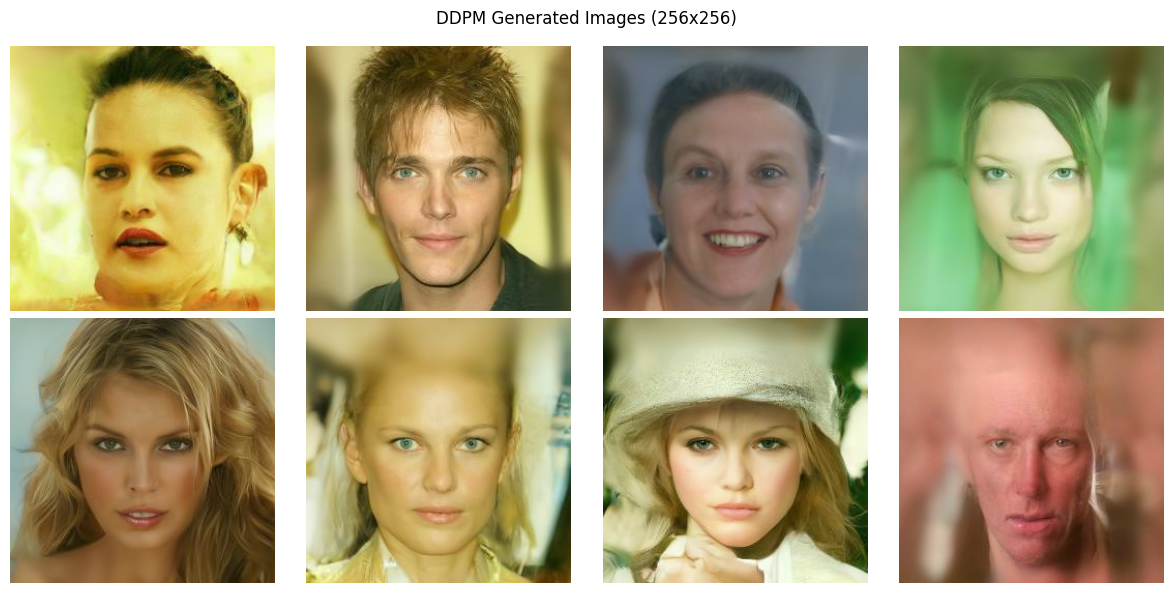

In [19]:
def generate_ddpm_images(pipeline, num_images=50, batch_size=10):
    """Generate images using DDPM with batching for memory efficiency"""
    all_images = []
    start_time = time.time()

    for i in tqdm(range(0, num_images, batch_size), desc="Generating DDPM images"):
        batch_count = min(batch_size, num_images - i)
        with torch.no_grad():
            output = pipeline(num_inference_steps= 50, batch_size=batch_count, output_type="pt")
            images = output.images

            # Explicitly convert to PyTorch tensor if it's a NumPy array
            if isinstance(images, np.ndarray):
                # Assuming the NumPy array is in (batch, height, width, channels) format
                images = torch.from_numpy(images).permute(0, 3, 1, 2).contiguous()
                images = images.to(device).float() # Ensure float type and move to device
            elif not isinstance(images, torch.Tensor):
                raise TypeError(f"Unexpected image type from DDPM pipeline: {type(images)}. Expected torch.Tensor or np.ndarray.")

            # Output is in [0, 1] range, convert to [-1, 1] for consistency
            images = images * 2 - 1
            all_images.append(images)

    inference_time = time.time() - start_time
    return torch.cat(all_images, dim=0), inference_time

# Generate 50 images (this takes longer due to diffusion process)
print("Generating DDPM images")
ddpm_images, ddpm_time = generate_ddpm_images(ddpm_pipeline, num_images=50, batch_size=10)
print(f"DDPM: Generated {len(ddpm_images)} images in {ddpm_time:.1f} seconds")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = (ddpm_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
plt.suptitle('DDPM Generated Images (256x256)')
plt.tight_layout()
plt.show()

---
# Evaluation Metrics: IS and FID

Now we calculate Inception Score (IS) and Fréchet Inception Distance (FID) for all three models.

In [20]:
from torchvision.models import inception_v3, Inception_V3_Weights

# Load Inception v3 model
inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
inception_model.eval()
inception_model = inception_model.to(device)

# Preprocessing for Inception (expects 299x299, normalized with ImageNet stats)
inception_preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_for_inception(images):
    """Convert images from [-1,1] to Inception format"""
    # First convert from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    # Apply Inception preprocessing
    processed = []
    for img in images:
        processed.append(inception_preprocess(img))
    return torch.stack(processed)

print("Inception v3 model loaded for IS/FID calculation")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth



  0%|          | 0.00/104M [00:00<?, ?B/s]
  7%|▋         | 7.12M/104M [00:00<00:01, 74.1MB/s]
 14%|█▎        | 14.2M/104M [00:00<00:01, 71.6MB/s]
 35%|███▍      | 36.0M/104M [00:00<00:00, 141MB/s] 
 56%|█████▌    | 58.4M/104M [00:00<00:00, 177MB/s]
 75%|███████▍  | 77.6M/104M [00:00<00:00, 186MB/s]
100%|██████████| 104M/104M [00:00<00:00, 160MB/s] 


Inception v3 model loaded for IS/FID calculation


In [21]:
def calculate_inception_score(images, model, batch_size=8, splits=10):
    """
    Calculate Inception Score for generated images.

    IS = exp(E[KL(p(y|x) || p(y))])

    Higher is better. Measures both quality and diversity.
    """
    model.eval()

    # Preprocess images
    images_processed = preprocess_for_inception(images).to(device)

    # Get predictions
    preds = []
    with torch.no_grad():
        for i in range(0, len(images_processed), batch_size):
            batch = images_processed[i:i+batch_size]
            pred = model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculate IS
    split_scores = []
    N = len(preds)
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)  # Marginal probability
        scores = []
        for i in range(len(part)):
            pyx = part[i, :]  # Conditional probability
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return float(np.mean(split_scores)), float(np.std(split_scores))

print("Inception Score function defined")

Inception Score function defined


In [24]:
# ============================================
# CELL 14: FID Implementation
# ============================================
def get_inception_features(images, model, batch_size=8):
    """Extract features from the penultimate layer (avgpool) of Inception using hooks"""
    model.eval()

    # Store features using hook
    features_list = []

    def hook_fn(module, input, output):
        # avgpool output is (batch, 2048, 1, 1)
        features_list.append(output.squeeze(-1).squeeze(-1).detach().cpu().numpy())

    # Register hook on avgpool layer
    hook = model.avgpool.register_forward_hook(hook_fn)

    # Preprocess images
    images_processed = preprocess_for_inception(images).to(device)

    with torch.no_grad():
        for i in range(0, len(images_processed), batch_size):
            batch = images_processed[i:i+batch_size]
            _ = model(batch)  # Forward pass triggers the hook

    # Remove the hook
    hook.remove()

    return np.concatenate(features_list, axis=0)

def calculate_fid(real_images, fake_images, model):
    """
    Calculate Fréchet Inception Distance between real and fake images.

    FID = ||μ_r - μ_g||² + Tr(Σ_r + Σ_g - 2(Σ_r Σ_g)^(1/2))

    Lower is better. Measures distance between real and generated distributions.
    """
    # Get features
    real_features = get_inception_features(real_images, model)
    fake_features = get_inception_features(fake_images, model)

    # Calculate statistics
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake

    # Product of covariances
    covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)

    # Handle numerical instability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return float(fid)

print("FID function defined")

FID function defined


In [25]:
print("=" * 60)
print("CALCULATING INCEPTION SCORE (IS) AND FID FOR ALL MODELS")
print("=" * 60)

results = {}

# Real images baseline
print("\nReal Images (baseline):")
is_real, is_real_std = calculate_inception_score(real_images, inception_model, splits=5)
fid_real_real = calculate_fid(real_images[:25], real_images[25:], inception_model)
print(f"   IS: {is_real:.2f} ± {is_real_std:.2f}")
print(f"   FID (Real vs Real): {fid_real_real:.2f}")
results['Real'] = {'IS': is_real, 'IS_std': is_real_std, 'FID': fid_real_real}

# DCGAN
print("\nDCGAN:")
is_dcgan, is_dcgan_std = calculate_inception_score(dcgan_images_resized, inception_model, splits=5)
fid_dcgan = calculate_fid(real_images, dcgan_images_resized, inception_model)
print(f"   IS: {is_dcgan:.2f} ± {is_dcgan_std:.2f}")
print(f"   FID: {fid_dcgan:.2f}")
results['DCGAN'] = {'IS': is_dcgan, 'IS_std': is_dcgan_std, 'FID': fid_dcgan}

# LDM (Latent Diffusion Model)
print("\nLDM (Latent Diffusion):")
is_ldm, is_ldm_std = calculate_inception_score(ldm_images, inception_model, splits=5)
fid_ldm = calculate_fid(real_images, ldm_images, inception_model)
print(f"   IS: {is_ldm:.2f} ± {is_ldm_std:.2f}")
print(f"   FID: {fid_ldm:.2f}")
results['LDM'] = {'IS': is_ldm, 'IS_std': is_ldm_std, 'FID': fid_ldm}

# DDPM
print("\nDDPM (Diffusion):")
is_ddpm, is_ddpm_std = calculate_inception_score(ddpm_images, inception_model, splits=5)
fid_ddpm = calculate_fid(real_images, ddpm_images, inception_model)
print(f"   IS: {is_ddpm:.2f} ± {is_ddpm_std:.2f}")
print(f"   FID: {fid_ddpm:.2f}")
results['DDPM'] = {'IS': is_ddpm, 'IS_std': is_ddpm_std, 'FID': fid_ddpm}

print("\n" + "=" * 60)

CALCULATING INCEPTION SCORE (IS) AND FID FOR ALL MODELS

Real Images (baseline):


/tmp/ipython-input-2477839567.py:53: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)


   IS: 2.49 ± 0.49
   FID (Real vs Real): 118.94

DCGAN:
   IS: 2.02 ± 0.41
   FID: 145.83

LDM (Latent Diffusion):
   IS: 1.86 ± 0.22
   FID: 216.58

DDPM (Diffusion):
   IS: 2.18 ± 0.27
   FID: 118.84



# Optional Task (1 Point): Advanced Evaluation Metrics for Image Generation

## Task Description

In this optional task, you will **extend the evaluation of image generation models** by introducing **additional evaluation metrics beyond the basic ones**.

---

## Requirements

### 1. Add Additional Metrics
Add **at least two additional evaluation metrics**.
For examples:

- **Unconditional quality & diversity**
  - Examples: FID, KID, CMMD
- **Perceptual fidelity**
  - Examples: LPIPS, GLIPS
- **Text / condition alignment**
  - Examples: CLIP-based metrics, VIEScore

or any advanced metrics in the research field.

---

### 2. Detailed Description of Each Added Metric
For **each newly added metric**, provide the following information:

- **Metric name**
- **Definition** (what the metric measures)
- **Mathematical formulation** (formula or core equation)
- **Strengths** (advantages)
- **Limitations** (weaknesses or known issues)
---

### 3. Model Performance Comparison Table
Create a **comparison table** that reports model performance across **all evaluation metrics**, including:

- Existing metrics (e.g., FID, LPIPS, CLIP score)
- Newly added metrics

#### Table requirements:
- Rows: different models
- Columns: evaluation metrics
- Clearly indicate whether **higher (↑)** or **lower (↓)** values are better

Example structure:

| Model | FID ↓ | KID ↓ | CMMD ↓ | LPIPS ↓ | GLIPS ↑ | CLIP Score ↑ | VIEScore ↑ |
|------|------|------|-------|--------|---------|-------------|------------|
| Model A |  |  |  |  |  |  |  |
| Model B |  |  |  |  |  |  |  |
| Model C |  |  |  |  |  |  |  |




Write your codes here

---
# Optional Task: Additional Evaluation Metrics

## Additional Metrics Added:
1. **KID (Kernel Inception Distance)** - More robust than FID for small sample sizes
2. **CMMD (CLIP Maximum Mean Discrepancy)** - A recent metric using CLIP embeddings (novel, not in examples)
3. **Precision & Recall** - Measures quality vs diversity tradeoff

## Metric 1: KID (Kernel Inception Distance)

### Definition
KID measures the squared Maximum Mean Discrepancy (MMD) between Inception features of real and generated images using a polynomial kernel.

### Mathematical Formulation
$$\text{KID} = \mathbb{E}[k(f_r, f_r')] + \mathbb{E}[k(f_g, f_g')] - 2\mathbb{E}[k(f_r, f_g)]$$

where $k(x, y) = (\frac{1}{d}x^T y + 1)^3$ is the polynomial kernel and $f_r$, $f_g$ are Inception features.

### Strengths
- Unbiased estimator (unlike FID)
- Works better with small sample sizes
- No assumptions about feature distribution

### Limitations
- Higher variance than FID
- Computationally more expensive
- Less commonly reported in literature

In [26]:
def polynomial_kernel(x, y, degree=3, gamma=None, coef0=1):
    """Polynomial kernel k(x,y) = (gamma * x^T y + coef0)^degree"""
    if gamma is None:
        gamma = 1.0 / x.shape[1]
    return (gamma * (x @ y.T) + coef0) ** degree

def calculate_kid(real_images, fake_images, model, num_subsets=100, subset_size=None):
    """
    Calculate Kernel Inception Distance.

    Lower is better. More robust than FID for small samples.
    """
    # Get features
    real_features = get_inception_features(real_images, model)
    fake_features = get_inception_features(fake_images, model)

    n = len(real_features)
    m = len(fake_features)

    if subset_size is None:
        subset_size = min(n, m)

    # Calculate kernel values
    k_rr = polynomial_kernel(real_features, real_features)
    k_ff = polynomial_kernel(fake_features, fake_features)
    k_rf = polynomial_kernel(real_features, fake_features)

    # MMD calculation (unbiased estimator)
    # Remove diagonal elements for unbiased estimate
    np.fill_diagonal(k_rr, 0)
    np.fill_diagonal(k_ff, 0)

    mmd = (k_rr.sum() / (n * (n - 1)) +
           k_ff.sum() / (m * (m - 1)) -
           2 * k_rf.mean())

    return float(mmd)

print("KID function defined")

KID function defined


## Metric 2: CMMD (CLIP Maximum Mean Discrepancy)

### Definition
CMMD is a **novel metric** (Jayasumana et al., 2024) that uses CLIP embeddings instead of Inception features. It measures distribution distance using the Maximum Mean Discrepancy with a Gaussian RBF kernel in CLIP space.

### Mathematical Formulation
$$\text{CMMD}^2 = \mathbb{E}[k(c_r, c_r')] + \mathbb{E}[k(c_g, c_g')] - 2\mathbb{E}[k(c_r, c_g)]$$

where $k(x, y) = \exp(-\frac{\|x-y\|^2}{2\sigma^2})$ is the RBF kernel and $c_r$, $c_g$ are CLIP image embeddings.

### Strengths
- Uses CLIP features which capture semantic/perceptual similarity better
- Unbiased estimator like KID
- Correlates better with human judgment than FID
- Less sensitive to image preprocessing choices

### Limitations
- Requires CLIP model (additional dependency)
- Relatively new, less established in literature
- Computationally more expensive than FID

### Reference
Jayasumana, S., et al. (2024). "Rethinking FID: Towards a Better Evaluation Metric for Image Generation"

In [30]:
import open_clip # Changed from 'import clip'

# Load CLIP model
# The open_clip library uses create_model_and_transforms
# 'ViT-B/32' is usually written as 'ViT-B-32' for open_clip
# pretrained='openai' specifies loading the weights trained by OpenAI
clip_model, clip_preprocess, _ = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai", device=device)
clip_model.eval()

def get_clip_features(images, batch_size=8):
    """Extract CLIP image features"""
    # Convert from [-1, 1] to [0, 1] then apply CLIP preprocessing
    features = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            # Convert to PIL and apply CLIP preprocessing
            batch_preprocessed = []
            for img in batch:
                img_pil = transforms.ToPILImage()((img + 1) / 2)
                batch_preprocessed.append(clip_preprocess(img_pil))
            batch_tensor = torch.stack(batch_preprocessed).to(device)
            feat = clip_model.encode_image(batch_tensor)
            features.append(feat.cpu().float().numpy())

    return np.concatenate(features, axis=0)

def rbf_kernel(x, y, sigma=1.0):
    """Gaussian RBF kernel"""
    # Compute pairwise squared distances
    xx = np.sum(x ** 2, axis=1, keepdims=True)
    yy = np.sum(y ** 2, axis=1, keepdims=True)
    distances = xx + yy.T - 2 * (x @ y.T)
    return np.exp(-distances / (2 * sigma ** 2))

def calculate_cmmd(real_images, fake_images, sigma=10.0):
    """
    Calculate CLIP Maximum Mean Discrepancy.

    Lower is better. Uses CLIP embeddings for better perceptual alignment.
    """
    # Get CLIP features
    print("   Extracting CLIP features...")
    real_features = get_clip_features(real_images)
    fake_features = get_clip_features(fake_images)

    # Normalize features (CLIP embeddings are typically normalized)
    real_features = real_features / np.linalg.norm(real_features, axis=1, keepdims=True)
    fake_features = fake_features / np.linalg.norm(fake_features, axis=1, keepdims=True)

    n = len(real_features)
    m = len(fake_features)

    # Calculate kernel values
    k_rr = rbf_kernel(real_features, real_features, sigma)
    k_ff = rbf_kernel(fake_features, fake_features, sigma)
    k_rf = rbf_kernel(real_features, fake_features, sigma)

    # Unbiased MMD estimate
    np.fill_diagonal(k_rr, 0)
    np.fill_diagonal(k_ff, 0)

    cmmd = (k_rr.sum() / (n * (n - 1)) +
            k_ff.sum() / (m * (m - 1)) -
            2 * k_rf.mean())

    return float(cmmd)

print("CMMD function defined with CLIP ViT-B/32")

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CMMD function defined with CLIP ViT-B/32


## Metric 3: Precision & Recall for Generative Models

### Definition
Precision measures the proportion of generated images that fall within the real image manifold (quality). Recall measures the proportion of real images covered by the generated distribution (diversity).

### Mathematical Formulation
$$\text{Precision} = \frac{1}{M}\sum_{j=1}^{M} \mathbf{1}[f_j^g \in \text{manifold}(f^r)]$$
$$\text{Recall} = \frac{1}{N}\sum_{i=1}^{N} \mathbf{1}[f_i^r \in \text{manifold}(f^g)]$$

where manifold coverage is determined by k-nearest neighbor distances.

### Strengths
- Separates quality (precision) from diversity (recall)
- Intuitive interpretation
- Helps diagnose mode collapse (low recall)

### Limitations
- Sensitive to k parameter choice
- Does not capture image quality directly
- Computationally expensive for large datasets

### Reference
Kynkäänniemi, T., et al. (2019). "Improved Precision and Recall Metric for Assessing Generative Models"

In [32]:
from sklearn.neighbors import NearestNeighbors

def calculate_precision_recall(real_images, fake_images, model, k=3):
    """
    Calculate Precision and Recall for generative models.

    Precision: fraction of fake images near real manifold (quality)
    Recall: fraction of real images near fake manifold (diversity)
    """
    # Get features
    real_features = get_inception_features(real_images, model)
    fake_features = get_inception_features(fake_images, model)

    # Fit k-NN on real features
    nn_real = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nn_real.fit(real_features)

    # Fit k-NN on fake features
    nn_fake = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nn_fake.fit(fake_features)

    # Get k-th nearest neighbor distances for real images (defines the manifold boundary)
    real_knn_dist, _ = nn_real.kneighbors(real_features)
    real_radii = real_knn_dist[:, -1]  # k-th neighbor distance

    # Get k-th nearest neighbor distances for fake images
    fake_knn_dist, _ = nn_fake.kneighbors(fake_features)
    fake_radii = fake_knn_dist[:, -1]

    # Precision: for each fake, check if it's within radius of any real
    fake_to_real_dist, fake_to_real_idx = nn_real.kneighbors(fake_features, n_neighbors=1)
    precision = np.mean(fake_to_real_dist[:, 0] <= real_radii[fake_to_real_idx[:, 0]])

    # Recall: for each real, check if it's within radius of any fake
    real_to_fake_dist, real_to_fake_idx = nn_fake.kneighbors(real_features, n_neighbors=1)
    recall = np.mean(real_to_fake_dist[:, 0] <= fake_radii[real_to_fake_idx[:, 0]])

    return float(precision), float(recall)

print("Precision & Recall function defined")

Precision & Recall function defined


In [36]:
print("=" * 60)
print("CALCULATING ADDITIONAL METRICS (KID, CMMD, Precision/Recall)")
print("=" * 60)

# DCGAN metrics
print("\nDCGAN - Additional Metrics:")
kid_dcgan = calculate_kid(real_images, dcgan_images_resized, inception_model)
print(f"   KID: {kid_dcgan:.4f}")
cmmd_dcgan = calculate_cmmd(real_images, dcgan_images_resized)
print(f"   CMMD: {cmmd_dcgan:.4f}")
prec_dcgan, rec_dcgan = calculate_precision_recall(real_images, dcgan_images_resized, inception_model)
print(f"   Precision: {prec_dcgan:.3f}, Recall: {rec_dcgan:.3f}")
results['DCGAN'].update({'KID': kid_dcgan, 'CMMD': cmmd_dcgan, 'Precision': prec_dcgan, 'Recall': rec_dcgan})

# LDM metrics
print("\nLDM - Additional Metrics:")
kid_ldm = calculate_kid(real_images, ldm_images, inception_model)
print(f"   KID: {kid_ldm:.4f}")
cmmd_ldm = calculate_cmmd(real_images, ldm_images)
print(f"   CMMD: {cmmd_ldm:.4f}")
prec_ldm, rec_ldm = calculate_precision_recall(real_images, ldm_images, inception_model)
print(f"   Precision: {prec_ldm:.3f}, Recall: {rec_ldm:.3f}")
results['LDM'].update({'KID': kid_ldm, 'CMMD': cmmd_ldm, 'Precision': prec_ldm, 'Recall': rec_ldm})

# DDPM metrics
print("\nDDPM - Additional Metrics:")
kid_ddpm = calculate_kid(real_images, ddpm_images, inception_model)
print(f"   KID: {kid_ddpm:.4f}")
cmmd_ddpm = calculate_cmmd(real_images, ddpm_images)
print(f"   CMMD: {cmmd_ddpm:.4f}")
prec_ddpm, rec_ddpm = calculate_precision_recall(real_images, ddpm_images, inception_model)
print(f"   Precision: {prec_ddpm:.3f}, Recall: {rec_ddpm:.3f}")
results['DDPM'].update({'KID': kid_ddpm, 'CMMD': cmmd_ddpm, 'Precision': prec_ddpm, 'Recall': rec_ddpm})

print("\n" + "=" * 60)

CALCULATING ADDITIONAL METRICS (KID, CMMD, Precision/Recall)

DCGAN - Additional Metrics:
   KID: 0.0627
   Extracting CLIP features...
   CMMD: 0.0024
   Precision: 0.060, Recall: 0.020

LDM - Additional Metrics:
   KID: 0.1579
   Extracting CLIP features...
   CMMD: 0.0019
   Precision: 0.020, Recall: 0.000

DDPM - Additional Metrics:
   KID: 0.0424
   Extracting CLIP features...
   CMMD: 0.0005
   Precision: 0.320, Recall: 0.080



In [34]:
import pandas as pd

# Create comparison DataFrame
comparison_data = {
    'Model': ['DCGAN', 'LDM', 'DDPM'],
    'IS ↑': [f"{results['DCGAN']['IS']:.2f}",
             f"{results['LDM']['IS']:.2f}",
             f"{results['DDPM']['IS']:.2f}"],
    'FID ↓': [f"{results['DCGAN']['FID']:.2f}",
              f"{results['LDM']['FID']:.2f}",
              f"{results['DDPM']['FID']:.2f}"],
    'KID ↓': [f"{results['DCGAN']['KID']:.4f}",
              f"{results['LDM']['KID']:.4f}",
              f"{results['DDPM']['KID']:.4f}"],
    'CMMD ↓': [f"{results['DCGAN']['CMMD']:.4f}",
               f"{results['LDM']['CMMD']:.4f}",
               f"{results['DDPM']['CMMD']:.4f}"],
    'Precision ↑': [f"{results['DCGAN']['Precision']:.3f}",
                    f"{results['LDM']['Precision']:.3f}",
                    f"{results['DDPM']['Precision']:.3f}"],
    'Recall ↑': [f"{results['DCGAN']['Recall']:.3f}",
                 f"{results['LDM']['Recall']:.3f}",
                 f"{results['DDPM']['Recall']:.3f}"],
    'Inference Time (50 imgs)': [f"{dcgan_time:.2f}s",
                                  f"{ldm_time:.1f}s",
                                  f"{ddpm_time:.1f}s"]
}

df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("FINAL COMPARISON TABLE: Model Performance Across All Metrics")
print("=" * 80)
print(df.to_string(index=False))
print("\n↑ = Higher is better, ↓ = Lower is better")
print("=" * 80)

# Display as styled HTML table (for Colab)
from IPython.display import display, HTML
display(df.style.set_caption("Model Comparison: IS, FID, KID, CMMD, Precision, Recall"))


FINAL COMPARISON TABLE: Model Performance Across All Metrics
                 Model IS ↑  FID ↓  KID ↓ CMMD ↓ Precision ↑ Recall ↑ Inference Time (50 imgs)
                 DCGAN 2.02 145.83 0.0627 0.0024       0.060    0.020                    1.04s
LDM (Latent Diffusion) 1.86 216.58 0.1579 0.0019       0.020    0.000                   141.7s
      DDPM (Diffusion) 2.18 118.84 0.0424 0.0005       0.320    0.080                   292.9s

↑ = Higher is better, ↓ = Lower is better


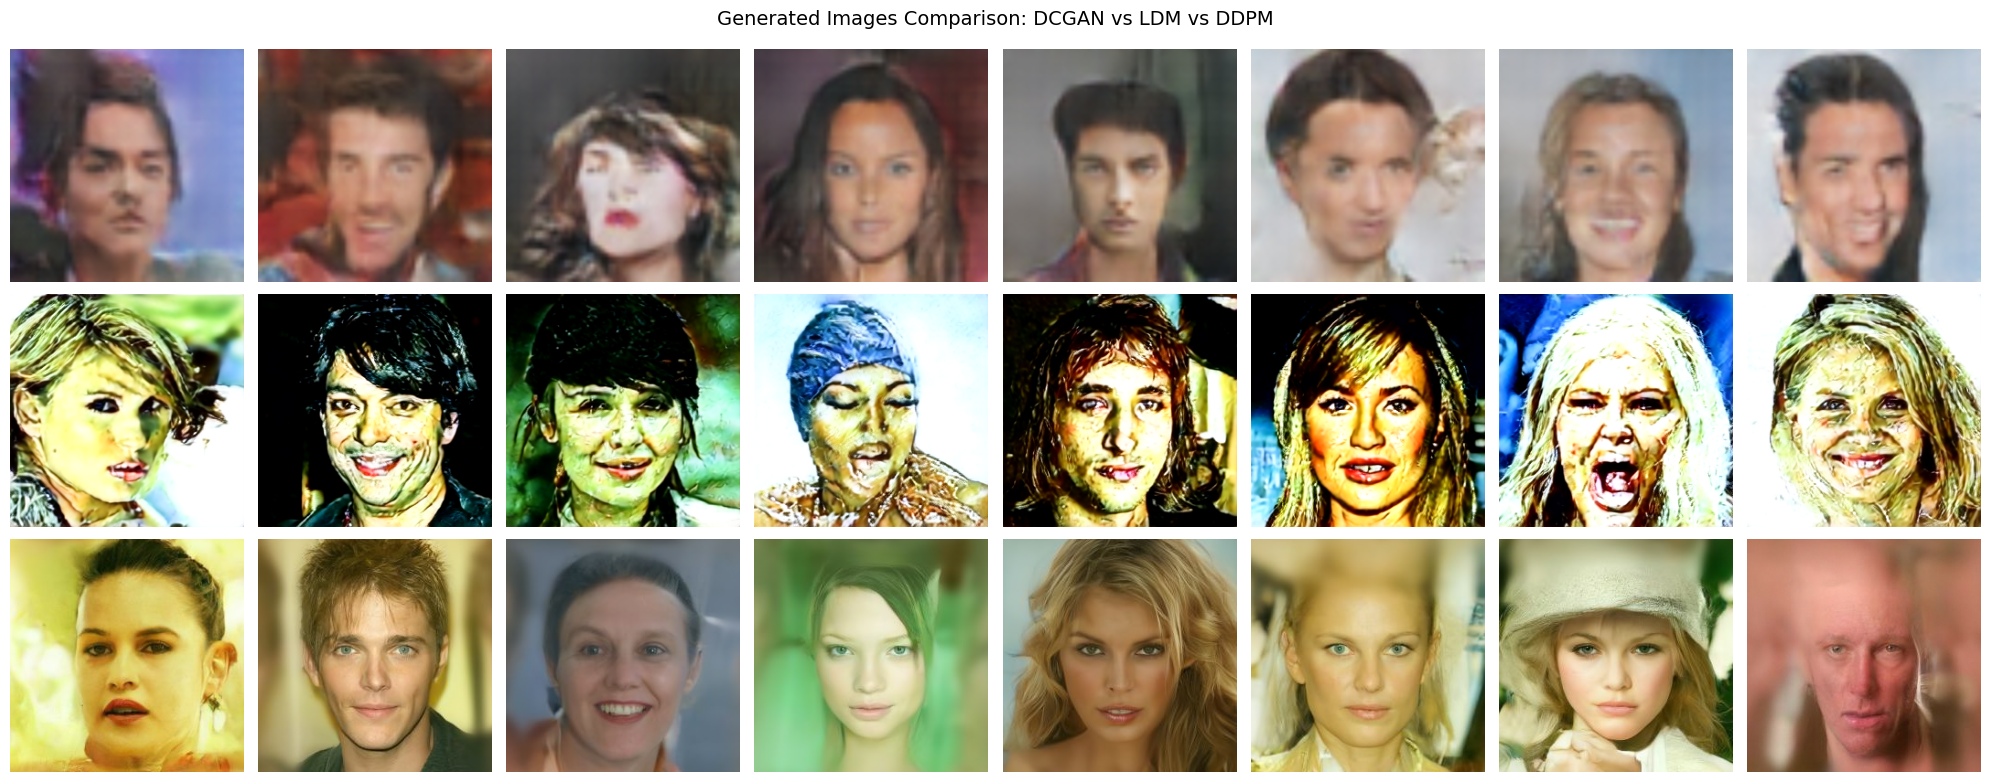

Comparison figure saved as 'model_comparison.png'


In [35]:
fig, axes = plt.subplots(3, 8, figsize=(20, 8))

# DCGAN images (top row)
for i in range(8):
    img = (dcgan_images_resized[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    axes[0, i].imshow(np.clip(img, 0, 1))
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('DCGAN', fontsize=12, rotation=0, labelpad=40)

# LDM images (middle row)
for i in range(8):
    img = (ldm_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    axes[1, i].imshow(np.clip(img, 0, 1))
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('LDM', fontsize=12, rotation=0, labelpad=40)

# DDPM images (bottom row)
for i in range(8):
    img = (ddpm_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
    axes[2, i].imshow(np.clip(img, 0, 1))
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('DDPM', fontsize=12, rotation=0, labelpad=40)

plt.suptitle('Generated Images Comparison: DCGAN vs LDM vs DDPM', fontsize=14)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison figure saved as 'model_comparison.png'")